In [1]:
# Load the model and dataset through the controller
from Controller.PredictingController import PredictingController
from LINDA_BN import permute, learn
import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import torch
from IPython.core.display import display, HTML
predictor = PredictingController()

/Users/jrhs/.pyenv/versions/dl/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)

| Preprocessed data loaded successfully 

| Model loaded successfully 


<Figure size 1600x800 with 0 Axes>

In [2]:
## show the training dataset head
predictor.train_dataset.dataset.df.head(5)

,trace,caseid
0,"[2, 12, 9, 10, 27, 28, 3, 17, 8, 15, 19, 33, 2...",173688
1,"[2, 12, 9, 10, 27, 28, 26, 28, 3, 17, 8, 15, 1...",173691
2,"[2, 12, 9, 10, 27, 28, 26, 28, 26, 28, 26, 28,...",173694
3,"[2, 12, 9, 7, 1]",173697
4,"[2, 12, 9, 7, 1]",173700


In [3]:
## Show the dict
predictor.dataset.index_to_vocab(2)

'<SOS>'

In [4]:
## Print vocaburaries with corresponded index.
predictor.dataset.vocab_dict

{'<EOS>': 1,
 '<SOS>': 2,
 'A_ACCEPTED_COMPLETE': 3,
 'A_ACTIVATED_COMPLETE': 4,
 'A_APPROVED_COMPLETE': 5,
 'A_CANCELLED_COMPLETE': 6,
 'A_DECLINED_COMPLETE': 7,
 'A_FINALIZED_COMPLETE': 8,
 'A_PARTLYSUBMITTED_COMPLETE': 9,
 'A_PREACCEPTED_COMPLETE': 10,
 'A_REGISTERED_COMPLETE': 11,
 'A_SUBMITTED_COMPLETE': 12,
 'O_ACCEPTED_COMPLETE': 13,
 'O_CANCELLED_COMPLETE': 14,
 'O_CREATED_COMPLETE': 15,
 'O_DECLINED_COMPLETE': 16,
 'O_SELECTED_COMPLETE': 17,
 'O_SENT_BACK_COMPLETE': 18,
 'O_SENT_COMPLETE': 19,
 'W_Afhandelen leads_COMPLETE': 20,
 'W_Afhandelen leads_SCHEDULE': 21,
 'W_Afhandelen leads_START': 22,
 'W_Beoordelen fraude_COMPLETE': 23,
 'W_Beoordelen fraude_SCHEDULE': 24,
 'W_Beoordelen fraude_START': 25,
 'W_Completeren aanvraag_COMPLETE': 26,
 'W_Completeren aanvraag_SCHEDULE': 27,
 'W_Completeren aanvraag_START': 28,
 'W_Nabellen incomplete dossiers_COMPLETE': 29,
 'W_Nabellen incomplete dossiers_SCHEDULE': 30,
 'W_Nabellen incomplete dossiers_START': 31,
 'W_Nabellen offertes


| Performing Evaluation on training dataset ... 
/Users/jrhs/Documents/GitHub/Apply-LINDA-BN-on-predicting-next-event/Data/BPI2012Dataset.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_seq_list = [torch.tensor(seq_list[idx])

| Evaluation result | Accuracy [0.8526] | Loss [3.4223] 

| Classification Report 
              precision    recall  f1-score   support

           1       1.00      0.97      0.99      1308
           3       0.00      0.00      0.00       495
           4       0.73      0.64      0.69       210
           5       0.58      0.73      0.65       210
           6       0.82      0.35      0.49       294
           7       1.00      0.05      0.10       766
           8       1.00      0.54      0.70       489
           9       1.00      1.00      1.00      1308
          10       0.00      0.00    

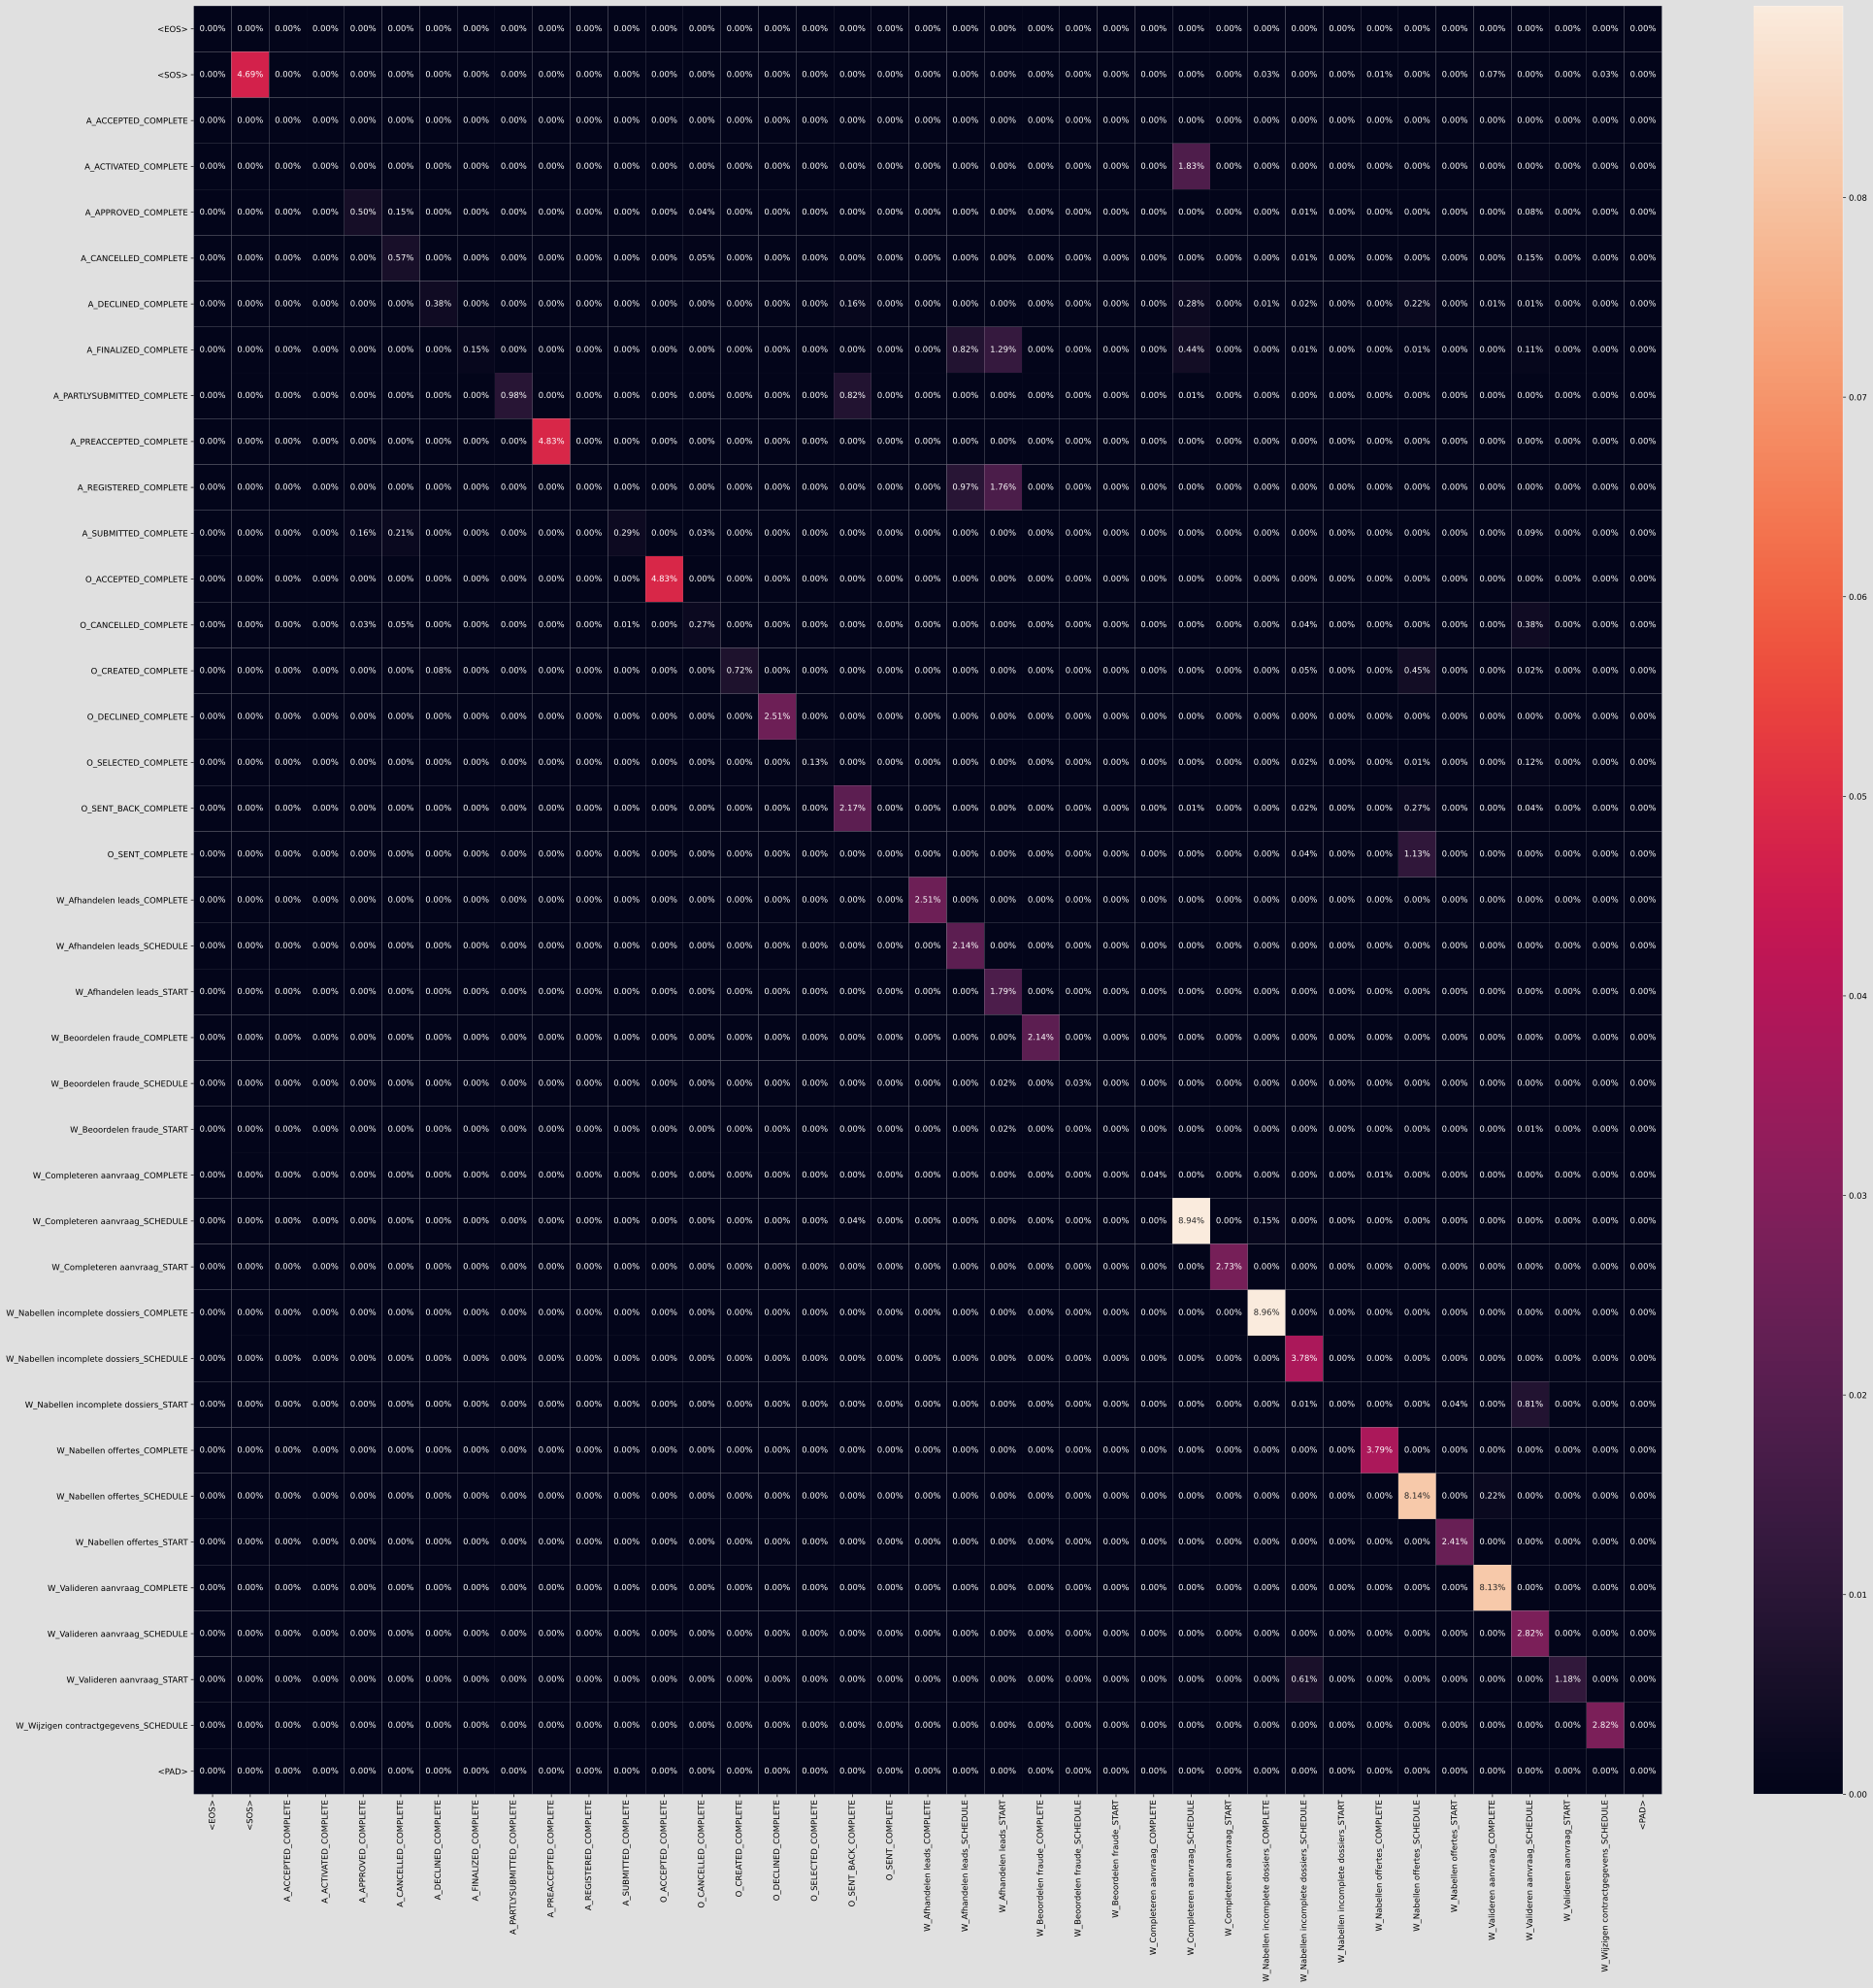

In [5]:
## Evaluation on training and test sets.abs
predictor.perform_eval_on_training_set()


| Performing Evaluation on test dataset ... 
/Users/jrhs/Documents/GitHub/Apply-LINDA-BN-on-predicting-next-event/Data/BPI2012Dataset.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_seq_list = [torch.tensor(seq_list[idx])

| Evaluation result | Accuracy [0.8530] | Loss [3.4244] 

| Classification Report 
              precision    recall  f1-score   support

           1       1.00      0.97      0.99      1308
           3       0.00      0.00      0.00       495
           4       0.73      0.64      0.69       210
           5       0.58      0.73      0.65       210
           6       0.82      0.35      0.49       294
           7       1.00      0.05      0.10       766
           8       1.00      0.54      0.70       489
           9       1.00      1.00      1.00      1308
          10       0.00      0.00      0.

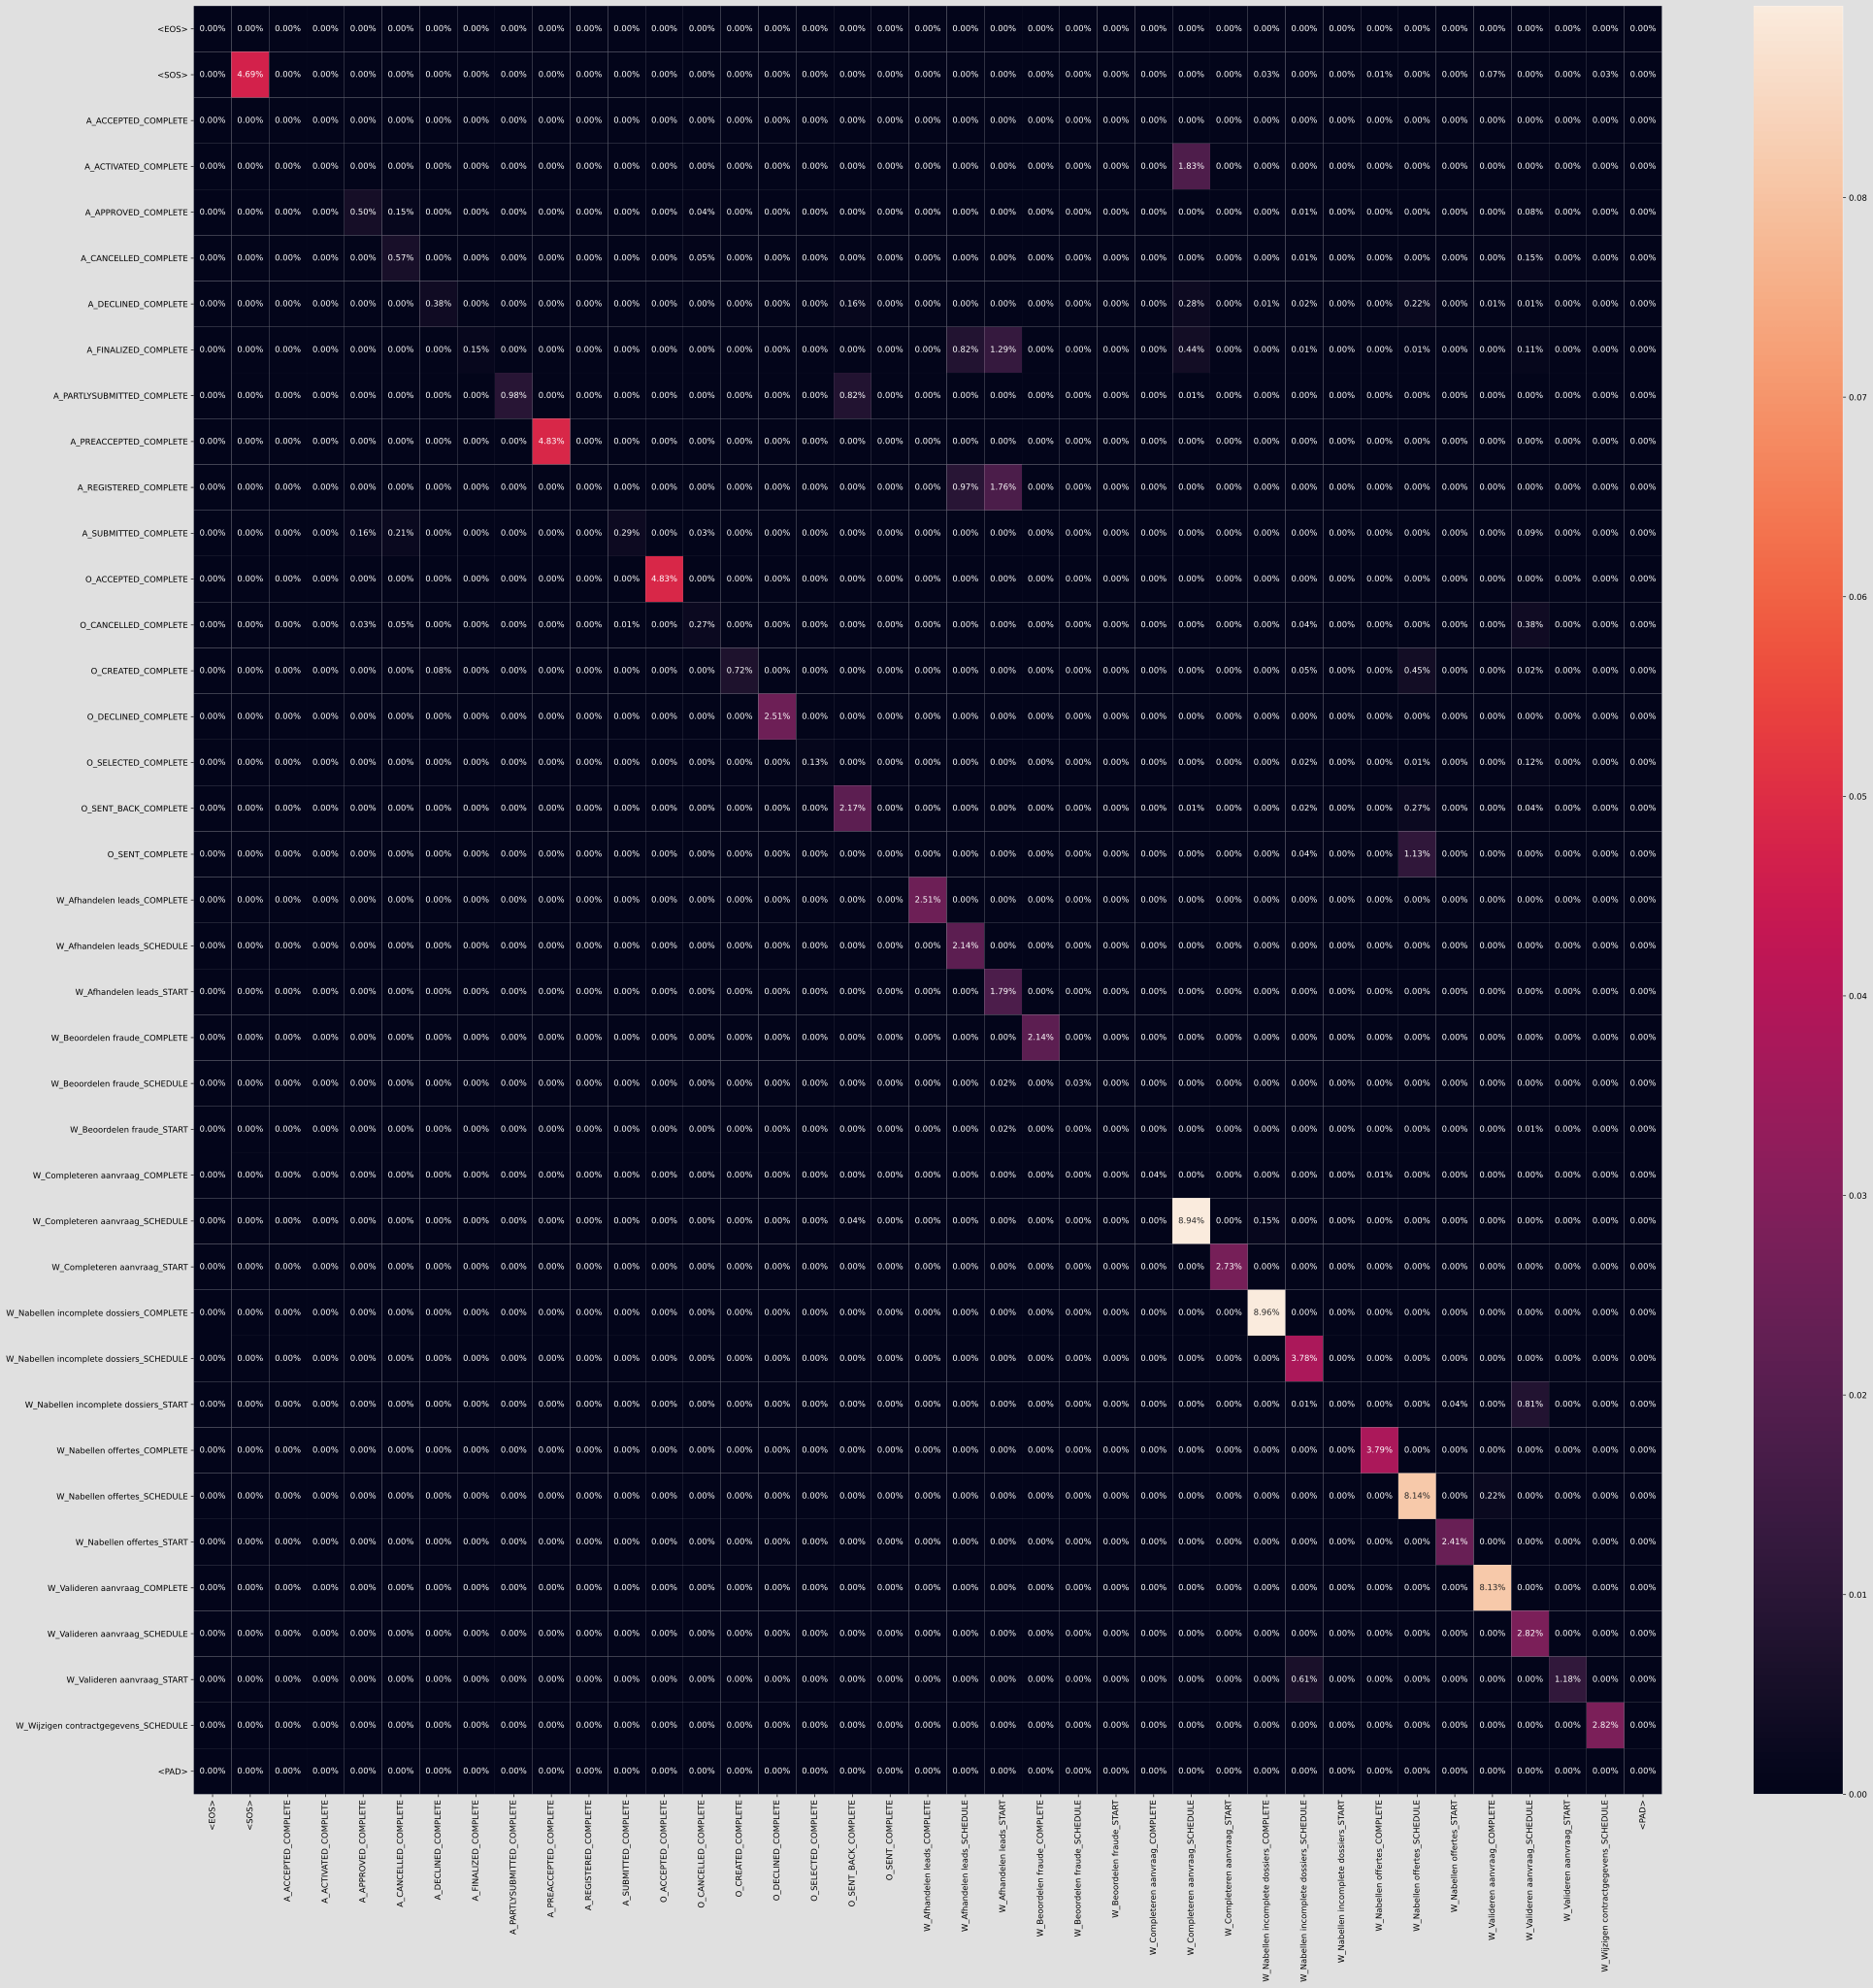

In [6]:
predictor.perform_eval_on_testing_set()

In [7]:
# TODO: find a true positive to permute
index_to_permute = 0
instance = predictor.test_dataset[index_to_permute]["trace"]
trace = instance[:-1]
target = instance[-1]
# generating the permutations for the trace
all_permutations = permute.generate_permutation_for_trace(np.array(trace), vocab_size=predictor.dataset.vocab_size())

In [8]:
permutation_t = torch.tensor(all_permutations)
predicted_list = predictor.predicting_from_list_of_idx_trace(data=permutation_t, n_steps=1, use_argmax=True )

# Convert to vocab list

predicted_vocab_list = [ predictor.dataset.list_of_index_to_vocab(p)  for  p in predicted_list]

col_names = [ "step_%d" % (i+1) for i in range(len(instance))]

df_to_dump = pd.DataFrame(predicted_vocab_list, columns=[col_names])

## Save the predicted and prediction to path
os.makedirs('./Permutations', exist_ok=True )
file_path = './Permutations/%d_permuted.csv' % index_to_permute

df_to_dump.to_csv(file_path, index=False)

bn, infoBN, essencGraph = learn.learnBN(file_path, algorithm=learn.BN_Algorithm.HillClimbing)

# compute Markov Blanket
markov_blanket = gum.MarkovBlanket(bn, col_names[-1])
activity_to_infer =  predictor.dataset.index_to_vocab(target)
inference = gnb.getInference(bn, evs={ col_names[-1] : activity_to_infer },targets=col_names, size="70" )



| Selecting Greedy Hill Climbing Algorithm 
/Users/jrhs/Documents/GitHub/Apply-LINDA-BN-on-predicting-next-event/Data/BPI2012Dataset.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_seq_list = [torch.tensor(seq_list[idx])


In [9]:
gnb.sideBySide(*[inference], captions=[ "Inference"])

In [10]:
s = gnb.sideBySide(*[markov_blanket, infoBN ], captions=[ "Markov Blanket", "Information BN" ])

In [11]:
## Saving 
path_to_explanation = './Explanations'
os.makedirs(path_to_explanation, exist_ok=True )

In [12]:
# Save info
with open (os.path.join(path_to_explanation, '%d_graphs_BN.html' % (index_to_permute)), 'w' )as output_file:
    output_file.write("<h1 style=\"text-align: center\">BN</h1>")
    output_file.write("<div style=\"text-align: center\">"+  gnb.getBN(bn) + "</div>")
    output_file.write('</br>'*5)
    output_file.write("<h1 style=\"text-align: center\">Inference</h1>")
    output_file.write(inference)
    output_file.write('</br>'*5)
    output_file.write("<h1 style=\"text-align: center\">Info BN</h1>")
    output_file.write(infoBN)
    output_file.write('</br>'*5)
    output_file.write("<h1 style=\"text-align: center\">Markov Blanket</h1>")
    output_file.write("<div style=\"text-align: center\">"+  markov_blanket._repr_html_() + "</div>")

In [13]:
# TODO: A activity -> Automatic classes


In [14]:
print("Runnable on m1 now")

Runnable on m1 now


In [15]:
[1,2,3,4,5] + [4,4,5]

[1, 2, 3, 4, 5, 4, 4, 5]